In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelEncoder
from scipy.sparse.linalg import svds
import skfuzzy as fuzz
from skfuzzy.cluster import cmeans
from surprise import Reader, Dataset, KNNWithMeans
from surprise.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler

C:\Users\mdsif\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\mdsif\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\mdsif\AppData\Local\Temp\ipykernel_12908\98624355.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
book_user = pd.read_csv(
    "books_data/users.csv", 
    on_bad_lines='skip', 
    encoding='ISO-8859-1', 
    sep=';', 
    header=0, 
    names=['User_ID', 'Location', 'Age'],
    quotechar='"', 
    escapechar='\\',
    dtype=str
)

# User dataset cleaning 

In [3]:
book_user

,User_ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [4]:
print(book_user.isnull().sum())

User_ID          0
Location         0
Age         110762
dtype: int64


In [5]:
book_user['Age'] = pd.to_numeric(book_user['Age'], errors='coerce')
book_user['Age'] = book_user['Age'].fillna(book_user['Age'].median())

In [6]:
book_user.fillna({'Age': book_user['Age'].median()}, inplace=True)

In [7]:
print(book_user.isnull().sum())

User_ID     0
Location    0
Age         0
dtype: int64


In [8]:
book_user['Location'] = book_user['Location'].str.strip()

In [9]:
book_user['Location']

0                         nyc, new york, usa
1                  stockton, california, usa
2            moscow, yukon territory, russia
3                  porto, v.n.gaia, portugal
4         farnborough, hants, united kingdom
                         ...                
278853                 portland, oregon, usa
278854    tacoma, washington, united kingdom
278855             brampton, ontario, canada
278856             knoxville, tennessee, usa
278857                  dublin, n/a, ireland
Name: Location, Length: 278858, dtype: object

In [10]:
book_user.replace('n/a', np.nan, inplace=True)

In [11]:
book_user['Age'] = pd.to_numeric(book_user['Age'], errors='coerce')

In [12]:
book_user['Age']

0         32.0
1         18.0
2         32.0
3         17.0
4         32.0
          ... 
278853    32.0
278854    50.0
278855    32.0
278856    32.0
278857    32.0
Name: Age, Length: 278858, dtype: float64

In [13]:
book_user['Location'] = book_user['Location'].astype(str)
location_split =book_user['Location'] .str.split(',', expand=True)

num_cols = location_split.shape[1]



column_names = ['City', 'State'] + [f'Extra_{i}'  for i in range(num_cols - 2)]


location_split.columns = column_names


In [14]:
book_user = pd.concat([book_user, location_split], axis=1)

In [15]:
book_user

,User_ID,Location,Age,City,State,Extra_0,Extra_1,Extra_2,Extra_3,Extra_4,Extra_5,Extra_6
0,1,"nyc, new york, usa",32.0,nyc,new york,usa,None,None,None,None,None,None
1,2,"stockton, california, usa",18.0,stockton,california,usa,None,None,None,None,None,None
2,3,"moscow, yukon territory, russia",32.0,moscow,yukon territory,russia,None,None,None,None,None,None
3,4,"porto, v.n.gaia, portugal",17.0,porto,v.n.gaia,portugal,None,None,None,None,None,None
4,5,"farnborough, hants, united kingdom",32.0,farnborough,hants,united kingdom,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
278853,278854,"portland, oregon, usa",32.0,portland,oregon,usa,None,None,None,None,None,None
278854,278855,"tacoma, washington, united kingdom",50.0,tacoma,washington,united kingdom,None,None,None,None,None,None
278855,278856,"brampton, ontario, canada",32.0,brampton,ontario,canada,None,None,None,None,None,None
278856,278857,"knoxville, tennessee, usa",32.0,knoxville,tennessee,usa,None,None,None,None,None,None


In [16]:
book_user.rename(columns={'Extra_0': 'Country'}, inplace=True)

extra_columns = [col for col in book_user if col.startswith('Extra_') and col != 'Country']
book_user.drop(columns=extra_columns, inplace=True)


print(book_user.head())


  User_ID                            Location   Age         City  \
0       1                  nyc, new york, usa  32.0          nyc   
1       2           stockton, california, usa  18.0     stockton   
2       3     moscow, yukon territory, russia  32.0       moscow   
3       4           porto, v.n.gaia, portugal  17.0        porto   
4       5  farnborough, hants, united kingdom  32.0  farnborough   

              State          Country  
0          new york              usa  
1        california              usa  
2   yukon territory           russia  
3          v.n.gaia         portugal  
4             hants   united kingdom  


In [17]:
book_user

,User_ID,Location,Age,City,State,Country
0,1,"nyc, new york, usa",32.0,nyc,new york,usa
1,2,"stockton, california, usa",18.0,stockton,california,usa
2,3,"moscow, yukon territory, russia",32.0,moscow,yukon territory,russia
3,4,"porto, v.n.gaia, portugal",17.0,porto,v.n.gaia,portugal
4,5,"farnborough, hants, united kingdom",32.0,farnborough,hants,united kingdom
...,...,...,...,...,...,...
278853,278854,"portland, oregon, usa",32.0,portland,oregon,usa
278854,278855,"tacoma, washington, united kingdom",50.0,tacoma,washington,united kingdom
278855,278856,"brampton, ontario, canada",32.0,brampton,ontario,canada
278856,278857,"knoxville, tennessee, usa",32.0,knoxville,tennessee,usa


In [18]:
print(book_user.isnull().sum())

User_ID     0
Location    0
Age         0
City        0
State       1
Country     2
dtype: int64


In [19]:
state_mode = book_user['State'].mode()[0]
country_mode = book_user['Country'].mode()[0]

book_user['State'] = book_user['State'].fillna(state_mode)
book_user['Country'] = book_user['Country'].fillna(country_mode)

In [20]:
print(book_user.isnull().sum())

User_ID     0
Location    0
Age         0
City        0
State       0
Country     0
dtype: int64


In [21]:
book_user

,User_ID,Location,Age,City,State,Country
0,1,"nyc, new york, usa",32.0,nyc,new york,usa
1,2,"stockton, california, usa",18.0,stockton,california,usa
2,3,"moscow, yukon territory, russia",32.0,moscow,yukon territory,russia
3,4,"porto, v.n.gaia, portugal",17.0,porto,v.n.gaia,portugal
4,5,"farnborough, hants, united kingdom",32.0,farnborough,hants,united kingdom
...,...,...,...,...,...,...
278853,278854,"portland, oregon, usa",32.0,portland,oregon,usa
278854,278855,"tacoma, washington, united kingdom",50.0,tacoma,washington,united kingdom
278855,278856,"brampton, ontario, canada",32.0,brampton,ontario,canada
278856,278857,"knoxville, tennessee, usa",32.0,knoxville,tennessee,usa


In [22]:
print(book_user.duplicated().sum())

0


# Books dataset cleaning 

In [23]:
books = pd.read_csv(
    "books_data/books.csv", 
    on_bad_lines='skip', 
    encoding='ISO-8859-1', 
    sep=';', 
    header=0, 
    names=['ISBN', 'Book_title', 'Book_author', 'Year_of_Publication', 'Publisher', 'url_S', 'url_m', 'url_l'],  # Replace with actual column names
    quotechar='"', 
    escapechar='\\',
    dtype=str
)

In [24]:
books

,ISBN,Book_title,Book_author,Year_of_Publication,Publisher,url_S,url_m,url_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271374,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271375,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271377,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [25]:
books.isnull().sum()

ISBN                   0
Book_title             0
Book_author            2
Year_of_Publication    0
Publisher              2
url_S                  0
url_m                  0
url_l                  0
dtype: int64

In [26]:
default_author = "Unknown Author"  
default_publisher = "Unknown Publisher" 

books.fillna({'Book_author': default_author, 'Publisher': default_publisher}, inplace=True)

In [27]:
books.isnull().sum()

ISBN                   0
Book_title             0
Book_author            0
Year_of_Publication    0
Publisher              0
url_S                  0
url_m                  0
url_l                  0
dtype: int64

In [28]:
all_books = pd.read_csv(
    "books_data/all_books.csv", 
)

In [29]:
all_books

,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,CS,1
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,CS,1
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,CS,1
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,CS,1
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,CS,1
4,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,CS,1
...,...,...,...,...,...,...,...
271373,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),Med,1
271374,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,Med,1
271375,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,Med,1
271376,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,Med,1


In [30]:
all_books.rename(columns={
    '0195153448': 'ISBN',
    'Classical Mythology': 'Book_title',
    'Mark P. O. Morford': 'Author',
    '2002': 'Year',
    'Oxford University Press': 'Publisher',
    'CS': 'Department',
    '1': 'Url_link'
}, inplace=True)

In [31]:
all_books

,ISBN,Book_title,Author,Year,Publisher,Department,Url_link
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,CS,1
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,CS,1
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,CS,1
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,CS,1
4,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,CS,1
...,...,...,...,...,...,...,...
271373,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),Med,1
271374,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,Med,1
271375,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,Med,1
271376,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,Med,1


In [32]:
merged_df = pd.merge(books, all_books, on='ISBN')

In [33]:
merged_df

,ISBN,Book_title_x,Book_author,Year_of_Publication,Publisher_x,url_S,url_m,url_l,Book_title_y,Author,Year,Publisher_y,Department,Url_link
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,CS,1
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,CS,1
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,CS,1
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,CS,1
4,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,CS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271373,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),Med,1
271374,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,From One to One Hundred,Teri Sloat,1991,Dutton Books,Med,1
271375,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,Med,1
271376,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,Republic (World's Classics),Plato,1996,Oxford University Press,Med,1


In [34]:
final_df = merged_df.drop(columns=['url_S', 'url_m', 'url_l', 'Book_title_y', 'Url_link'])


final_df = final_df.rename(columns={'Book_title_x': 'Book_title', 'Year_of_Publication': 'Year'})


final_df = final_df.drop(columns=['Publisher_y']).rename(columns={'Publisher_x': 'Publisher'})


In [35]:
books = final_df 

In [36]:
new_book_data = {
    'ISBN': '9022906116',
    'Book_title': np.nan, 
    'Author': np.nan,      
    'Year': 2004,          
    'Publisher': np.nan, 
    'Department': 'CS'    
}


next_index = books.index.max() + 1


books.loc[next_index] = new_book_data


books['ISBN'] = books['ISBN'].astype(str)


book_info = books[books['ISBN'] == '9022906116']


In [37]:
books

,ISBN,Book_title,Book_author,Year,Publisher,Author,Year,Department
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,Richard Bruce Wright,2001,CS
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,Carlo D'Este,1991,CS
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,Gina Bari Kolata,1999,CS
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,E. J. W. Barber,1999,CS
4,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,Amy Tan,1991,CS
...,...,...,...,...,...,...,...,...
271374,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,Teri Sloat,1991,Med
271375,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,Christine Wicker,2004,Med
271376,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,Plato,1996,Med
271377,0767409752,A Guided Tour of Rene Descartes' Meditations o...,Christopher Biffle,2000,McGraw-Hill Humanities/Social Sciences/Languages,Christopher Biffle,2000,Med


In [38]:
books.isnull().sum()

ISBN           0
Book_title     1
Book_author    1
Year           0
Publisher      1
Author         3
Year           0
Department     0
dtype: int64

In [39]:
books = books.fillna('Unknown')

In [40]:
books.isnull().sum()

ISBN           0
Book_title     0
Book_author    0
Year           0
Publisher      0
Author         0
Year           0
Department     0
dtype: int64

# Ratings

In [41]:
ratings = pd.read_csv(
    "books_data/ratings.csv", 
    on_bad_lines='skip', 
    encoding='ISO-8859-1', 
    sep=';', 
    header=0, 
    names=['User_ID', 'ISBN', 'Book_rating'],  
    quotechar='"', 
    escapechar='\\',
    dtype=str
)

In [42]:
ratings

,User_ID,ISBN,Book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [43]:
ratings.isnull().sum()

User_ID        0
ISBN           0
Book_rating    0
dtype: int64

In [44]:
ratings.duplicated().sum()

0

# Shapes check

In [45]:
book_user.shape

(278858, 6)

In [46]:
ratings.shape

(1149780, 3)

In [47]:
books.shape

(271379, 8)

In [48]:
ratings['User_ID'].value_counts().shape

(105283,)

# 2000 books rated by user

In [49]:
user_rating_counts = ratings['User_ID'].value_counts()
real_rated_users = user_rating_counts[user_rating_counts > 2000].index

In [50]:
real_rated_users.shape

(29,)

In [51]:
filtered_ratings = ratings[ratings['User_ID'].isin(real_rated_users)]


rating_df = filtered_ratings[['User_ID', 'ISBN', 'Book_rating']]

In [52]:
rating_df

,User_ID,ISBN,Book_rating
4330,278418,0006128831,0
4331,278418,0006542808,5
4332,278418,0020209606,0
4333,278418,0020418809,0
4334,278418,0020420900,0
...,...,...,...
1029010,245963,3125997100,0
1029011,245963,34266110950,0
1029012,245963,671770497,0
1029013,245963,844134598,0


# Those User  :  where 2000 rated book 

In [53]:
book_user_df = pd.merge(book_user, rating_df[['User_ID']], on='User_ID', how='inner')

In [54]:
book_user_df

,User_ID,Location,Age,City,State,Country
0,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
1,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
2,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
3,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
4,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
...,...,...,...,...,...,...
104022,278418,"omaha, nebraska, usa",32.0,omaha,nebraska,usa
104023,278418,"omaha, nebraska, usa",32.0,omaha,nebraska,usa
104024,278418,"omaha, nebraska, usa",32.0,omaha,nebraska,usa
104025,278418,"omaha, nebraska, usa",32.0,omaha,nebraska,usa


# Exploratory Data Analysis (EDA) 

In [55]:
book_user_df

,User_ID,Location,Age,City,State,Country
0,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
1,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
2,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
3,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
4,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
...,...,...,...,...,...,...
104022,278418,"omaha, nebraska, usa",32.0,omaha,nebraska,usa
104023,278418,"omaha, nebraska, usa",32.0,omaha,nebraska,usa
104024,278418,"omaha, nebraska, usa",32.0,omaha,nebraska,usa
104025,278418,"omaha, nebraska, usa",32.0,omaha,nebraska,usa


In [56]:
rating_df

,User_ID,ISBN,Book_rating
4330,278418,0006128831,0
4331,278418,0006542808,5
4332,278418,0020209606,0
4333,278418,0020418809,0
4334,278418,0020420900,0
...,...,...,...
1029010,245963,3125997100,0
1029011,245963,34266110950,0
1029012,245963,671770497,0
1029013,245963,844134598,0


In [57]:
book_user_df.isnull().sum()

User_ID     0
Location    0
Age         0
City        0
State       0
Country     0
dtype: int64

In [58]:
rating_df.isnull().sum()

User_ID        0
ISBN           0
Book_rating    0
dtype: int64

In [59]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104027 entries, 4330 to 1029014
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User_ID      104027 non-null  object
 1   ISBN         104027 non-null  object
 2   Book_rating  104027 non-null  object
dtypes: object(3)
memory usage: 3.2+ MB


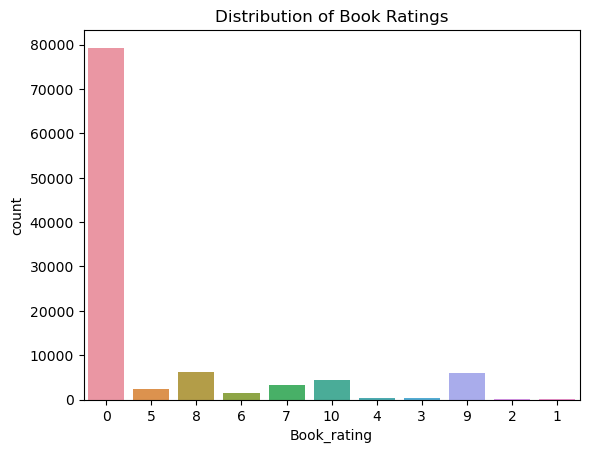

In [60]:
sns.countplot(x='Book_rating', data=rating_df)
plt.title('Distribution of Book Ratings')
plt.show()

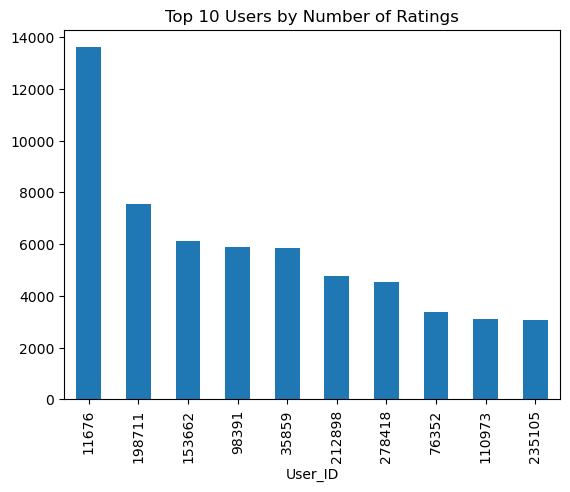

In [61]:
rating_df['User_ID'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Users by Number of Ratings')
plt.show()

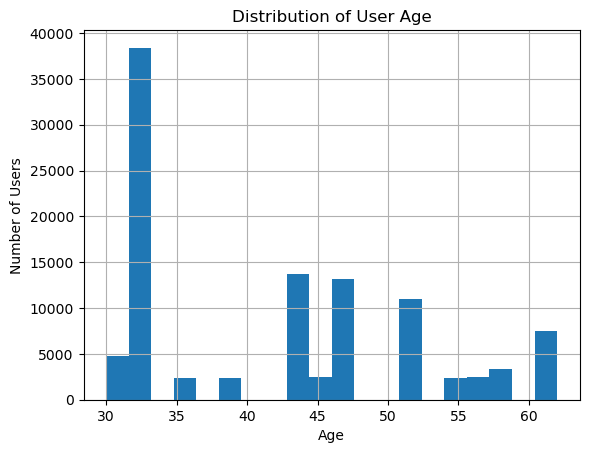

In [62]:
book_user_df['Age'].dropna().astype(int).hist(bins=20)
plt.title('Distribution of User Age')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()

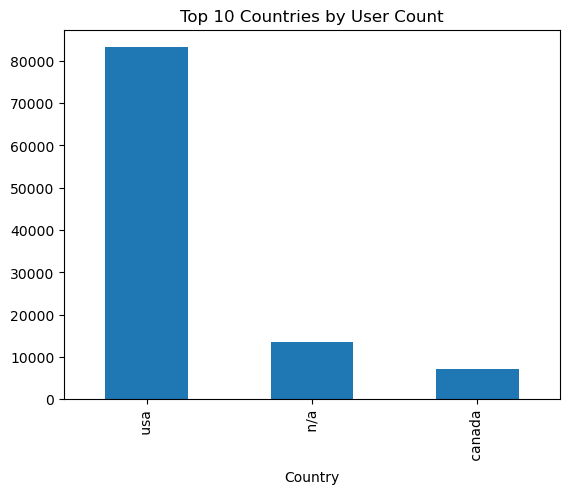

In [63]:
book_user_df['Country'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Countries by User Count')
plt.show()

# Final working in dataset

In [64]:
rating_df['Book_rating'] = pd.to_numeric(rating_df['Book_rating'], errors='coerce')

rating_df = rating_df.dropna(subset=['Book_rating'])

In [65]:
rating_df

,User_ID,ISBN,Book_rating
4330,278418,0006128831,0
4331,278418,0006542808,5
4332,278418,0020209606,0
4333,278418,0020418809,0
4334,278418,0020420900,0
...,...,...,...
1029010,245963,3125997100,0
1029011,245963,34266110950,0
1029012,245963,671770497,0
1029013,245963,844134598,0


In [66]:
book_user_df

,User_ID,Location,Age,City,State,Country
0,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
1,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
2,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
3,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
4,11676,"n/a, n/a, n/a",32.0,n/a,n/a,n/a
...,...,...,...,...,...,...
104022,278418,"omaha, nebraska, usa",32.0,omaha,nebraska,usa
104023,278418,"omaha, nebraska, usa",32.0,omaha,nebraska,usa
104024,278418,"omaha, nebraska, usa",32.0,omaha,nebraska,usa
104025,278418,"omaha, nebraska, usa",32.0,omaha,nebraska,usa


In [67]:
sample_size = 100000

max_sample_size = min(len(book_user_df['User_ID'].unique()), len(rating_df['User_ID'].unique()), sample_size)

unique_user_ids = np.random.choice(book_user_df['User_ID'].unique(), size=max_sample_size, replace=False)


book_user_df_deduped = book_user_df.drop_duplicates(subset='User_ID')


age_location_mapping = book_user_df_deduped.set_index('User_ID')[['Age', 'Location']].to_dict('index')


rating_df_deduped = rating_df.drop_duplicates(subset='User_ID')


ratings_mapping = rating_df_deduped.set_index('User_ID').loc[unique_user_ids]

book_user_new = pd.DataFrame({
    'User_ID': unique_user_ids,
    'Age': [age_location_mapping[uid]['Age'] for uid in unique_user_ids],
    'Location': [age_location_mapping[uid]['Location'] for uid in unique_user_ids]
})

ratings_new = pd.DataFrame({
    'User_ID': unique_user_ids,
    'ISBN': [ratings_mapping.loc[uid]['ISBN'] for uid in unique_user_ids],
    'Book_rating': [ratings_mapping.loc[uid]['Book_rating'] for uid in unique_user_ids]
})


book_user = book_user.sample(frac=1).reset_index(drop=True)
ratings = ratings.sample(frac=1).reset_index(drop=True)

In [68]:
book_user

,User_ID,Location,Age,City,State,Country
0,18591,"buffalo, new york, usa",32.0,buffalo,new york,usa
1,219759,"na, n/a, usa",32.0,na,n/a,usa
2,53971,"stockholm, stockholm, sweden",24.0,stockholm,stockholm,sweden
3,270704,"midwest city, oklahoma, usa",43.0,midwest city,oklahoma,usa
4,200034,"clover, south carolina, usa",32.0,clover,south carolina,usa
...,...,...,...,...,...,...
278853,100625,"turku, länsi-suomen lääni, finland",32.0,turku,länsi-suomen lääni,finland
278854,244607,"tempe, arizona, usa",41.0,tempe,arizona,usa
278855,231299,"new orleans, louisiana, usa",20.0,new orleans,louisiana,usa
278856,56893,"bay point, california, usa",32.0,bay point,california,usa


In [69]:

common_user_ids = np.intersect1d(book_user_df['User_ID'].unique(), rating_df['User_ID'].unique())
selected_user_ids = common_user_ids[:50]


book_user_df_deduped = book_user_df.drop_duplicates(subset='User_ID')
rating_df_deduped = rating_df.drop_duplicates(subset='User_ID')


age_location_mapping = book_user_df_deduped.set_index('User_ID')[['Age', 'Location']].to_dict('index')


ratings_mapping = rating_df_deduped.set_index('User_ID').loc[selected_user_ids]


book_user_new = pd.DataFrame({
    'User_ID': selected_user_ids,
    'Age': [age_location_mapping[uid]['Age'] for uid in selected_user_ids],
    'Location': [age_location_mapping[uid]['Location'] for uid in selected_user_ids]
})

ratings_new = pd.DataFrame({
    'User_ID': selected_user_ids,
    'ISBN': [ratings_mapping.loc[uid]['ISBN'] for uid in selected_user_ids],
    'Book_rating': [ratings_mapping.loc[uid]['Book_rating'] for uid in selected_user_ids]
})




In [70]:
book_user_new

,User_ID,Age,Location
0,102967,54.0,"olympia, washington, usa"
1,110973,43.0,"wiley ford, west virginia, usa"
2,11676,32.0,"n/a, n/a, n/a"
3,129358,36.0,"highland, california, usa"
4,135149,32.0,"ft. pierce, florida, usa"
5,153662,44.0,"ft. stewart, georgia, usa"
6,16795,47.0,"mechanicsville, maryland, usa"
7,171118,47.0,"toronto, ontario, canada"
8,185233,31.0,"winnemucca, nevada, usa"
9,190925,51.0,"hobe sound, florida, usa"


In [71]:
ratings_new

,User_ID,ISBN,Book_rating
0,102967,0020125305,5
1,110973,0006514634,0
2,11676,9022906116,7
3,129358,0060001453,0
4,135149,002026478X,0
5,153662,0002241447,0
6,16795,0006093090X,8
7,171118,0000913154,8
8,185233,0006169015,0
9,190925,*0515128325,0


In [72]:
encoder = OneHotEncoder(sparse=False)
location_encoded = encoder.fit_transform(book_user_new[['Location']])

In [73]:
age_normalized = (book_user_new['Age'] - book_user_new['Age'].min()) / (book_user_new['Age'].max() - book_user_new['Age'].min())
rating_normalized = (ratings_new['Book_rating'] - ratings_new['Book_rating'].min()) / (ratings_new['Book_rating'].max() - ratings_new['Book_rating'].min())

In [74]:
combined_features = np.hstack((age_normalized.values.reshape(-1, 1), rating_normalized.values.reshape(-1, 1), location_encoded))

# Fuzzy C-mean Cluster

In [75]:
age_normalized_np = age_normalized.to_numpy().reshape(-1, 1)
rating_normalized_np = rating_normalized.to_numpy().reshape(-1, 1)


location_encoded_np = location_encoded


X = np.concatenate((age_normalized_np, rating_normalized_np, location_encoded_np), axis=1)


num_clusters = 3


cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X.T,
    num_clusters,
    2,  
    error=0.005,
    maxiter=1000,
    init=None
)


cluster_membership = np.argmax(u, axis=0)

if len(cluster_membership) == len(book_user_new):
    
    book_user_new['Cluster'] = cluster_membership
else:
    raise ValueError(f"The length of the cluster_membership array ({len(cluster_membership)}) does not match the number of rows in the book_user_new DataFrame ({len(book_user_new)}).")

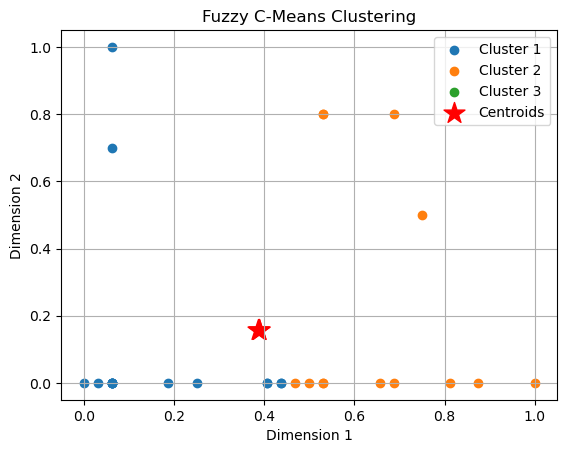

In [76]:
import matplotlib.pyplot as plt


cluster_membership = np.argmax(u, axis=0)


for j in range(num_clusters):
    plt.scatter(X[cluster_membership == j, 0],  # x-axis data for cluster j
                X[cluster_membership == j, 1],  # y-axis data for cluster j
                label=f'Cluster {j+1}')          # label for the plot

# Plot the cluster centers
plt.scatter(cntr[:, 0], cntr[:, 1], s=250, marker='*', c='red', label='Centroids')

plt.title('Fuzzy C-Means Clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
pivot_ratings = ratings_new.pivot_table(index='User_ID', columns='ISBN', values='Book_rating').fillna(0)

In [78]:
pivot_ratings

ISBN,9022906116,*0515128325,0000913154,000123207X,0001251782,0001981625,0002154307,0002159848,0002166631,0002177471,...,0006471641,0006514634,0007108265,0007157738,0020125305,0020199058,0020199201,002026478X,0060001445,0060001453
User_ID,,,,,,,,,,,,,,,,,,,,,
102967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
110973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11676,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
171118,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
cosine_sim = cosine_similarity(pivot_ratings)

# With Rating Recommended Books

# Collaborative filtering

In [80]:
user_id_to_index = {user_id: index for index, user_id in enumerate(pivot_ratings.index)}


def get_similar_users(target_user_id, cluster_id):
    target_user_index = user_id_to_index[target_user_id]
    cluster_user_ids = book_user_new[book_user_new['Cluster'] == cluster_id]['User_ID']
    cluster_user_indices = [user_id_to_index[user_id] for user_id in cluster_user_ids if user_id in user_id_to_index]
    
    similarities = cosine_sim[target_user_index][cluster_user_indices]
    sorted_users_indices = np.argsort(similarities)[::-1]
    similar_users = [cluster_user_ids.iloc[index] for index in sorted_users_indices]
    
    return similar_users


In [81]:
def recommend_books(target_user_id, num_recommendations=5):
    target_user_id = str(target_user_id) if isinstance(target_user_id, int) else target_user_id
    
   
    user_cluster = book_user_new[book_user_new['User_ID'] == target_user_id]
    
    if not user_cluster.empty:
        cluster_id = user_cluster['Cluster'].iloc[0]
        similar_users = get_similar_users(target_user_id, cluster_id)
        
       
        if similar_users:
            similar_user_indices = [user_id_to_index[user_id] for user_id in similar_users if user_id in user_id_to_index]
            
            if target_user_id in user_id_to_index:
                target_user_index = user_id_to_index[target_user_id]
              
                books_to_consider = pivot_ratings.iloc[similar_user_indices].mean(axis=0)
                
               
                already_rated = pivot_ratings.iloc[target_user_index] != 0
                
               
                books_to_consider = books_to_consider[~already_rated].sort_values(ascending=False)
                
                
                return books_to_consider.head(num_recommendations)
            else:
                return f"User ID {target_user_id} index not found in user_id_to_index mapping."
        else:
            return f"No similar users found for User ID {target_user_id}."
    else:
        return f"User ID {target_user_id} not found in book_user."


In [82]:
user_id = 278418
User_ID = str(user_id)  


if User_ID in user_id_to_index and User_ID in book_user_new['User_ID'].astype(str).str.strip().values:
    recommendations = recommend_books(user_id)
    if isinstance(recommendations, str):

        print(recommendations)
    else:
        print(recommendations) 
else:
    print(f"User ID {user_id} not found in the dataset.")

ISBN
0004722124     0.6250
 9022906116    0.4375
0006169015     0.0000
0060001445     0.0000
002026478X     0.0000
dtype: float64


In [83]:
recommended_isbns = pd.DataFrame(recommendations.index).rename(columns={0: 'ISBN'})

recommended_books_with_rating_data = recommended_isbns.merge(books, on='ISBN', how='left')


print(recommended_books_with_rating_data[['ISBN', 'Book_title']])

Collaborative_filtering_with_rating_data  = (recommended_books_with_rating_data[['ISBN', 'Book_title']])

          ISBN                                         Book_title
0   0004722124  Jane's Aircraft Recognition Guide (Jane's Airc...
1   9022906116                                                NaN
2   0006169015                                                NaN
3   0060001445                              Her Highness, My Wife
4   002026478X                    AGE OF INNOCENCE (MOVIE TIE-IN)


In [84]:
recommended_isbn_list = recommended_isbns['ISBN'].tolist()

In [85]:
recommended_isbn_list

['0004722124', ' 9022906116', '0006169015', '0060001445', '002026478X']

In [86]:
if '9022906116' in books['ISBN'].values:
    print("ISBN is present in the 'books' dataset.")
else:
    print("ISBN is not present in the 'books' dataset.")

ISBN is present in the 'books' dataset.


In [87]:
departments_for_recommended_books_with_rating_data = pd.DataFrame(recommended_isbn_list, columns=['ISBN'])


books['ISBN'] = books['ISBN'].astype(str).str.strip()
departments_for_recommended_books_with_rating_data['ISBN'] = departments_for_recommended_books_with_rating_data['ISBN'].astype(str).str.strip()


if 'Department' in books.columns:
    books['Department'] = books['Department'].astype(str)


for isbn in departments_for_recommended_books_with_rating_data['ISBN']:
   
    book_info = books[books['ISBN'] == isbn]
   
    if not book_info.empty:
        
        department = book_info['Department'].iloc[0]
        departments_for_recommended_books_with_rating_data.loc[
            departments_for_recommended_books_with_rating_data['ISBN'] == isbn, 'Department'] = department
    else:
       
        pass  


final_df = departments_for_recommended_books_with_rating_data.merge(
    books[['ISBN', 'Book_title', 'Author', 'Year', 'Publisher']], on='ISBN', how='left'
)




In [88]:
final_df

,ISBN,Department,Book_title,Author,Year,Year,Publisher
0,0004722124,Acc,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,1999.0,HarperResource
1,9022906116,CS,Unknown,Unknown,2004,2004.0,Unknown
2,0006169015,NaN,NaN,NaN,NaN,NaN,NaN
3,0060001445,CS,"Her Highness, My Wife",Victoria Alexander,2002,2002.0,Avon
4,002026478X,CS,AGE OF INNOCENCE (MOVIE TIE-IN),Edith Wharton,1993,1993.0,Scribner


In [89]:
departments_for_recommended_books_with_rating_data

,ISBN,Department
0,0004722124,Acc
1,9022906116,CS
2,0006169015,NaN
3,0060001445,CS
4,002026478X,CS


In [90]:
departments_for_recommended_books_with_rating_data = departments_for_recommended_books_with_rating_data.merge(
    books[['ISBN', 'Book_title', 'Book_author', 'Year', 'Publisher', 'Author']], 
    on='ISBN', 
    how='left'
)

In [91]:
departments_for_recommended_books_with_rating_data

,ISBN,Department,Book_title,Book_author,Year,Year,Publisher,Author
0,0004722124,Acc,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,1999.0,HarperResource,David Rendall
1,9022906116,CS,Unknown,Unknown,2004,2004.0,Unknown,Unknown
2,0006169015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0060001445,CS,"Her Highness, My Wife",Victoria Alexander,2002,2002.0,Avon,Victoria Alexander
4,002026478X,CS,AGE OF INNOCENCE (MOVIE TIE-IN),Edith Wharton,1993,1993.0,Scribner,Edith Wharton


# Content Base

In [92]:
authors_list = books[books['ISBN'].isin(recommended_isbn_list)]['Author'].unique().tolist()


for author in authors_list:
    author_books = books[books['Author'] == author]
    selected_books = author_books.head(2)

In [93]:
selected_books[['ISBN', 'Book_title', 'Author', 'Department']]

,ISBN,Book_title,Author,Department
67939,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,Acc


In [94]:
final_recommended_books_with_rating_data_1 =departments_for_recommended_books_with_rating_data.copy()
final_recommended_books_with_rating_data_2 = selected_books.copy()

In [95]:
final_recommended_books_with_rating_data = pd.concat(
    [final_recommended_books_with_rating_data_1.set_index('ISBN'), final_recommended_books_with_rating_data_2.set_index('ISBN')],
    axis=1,
    join='outer'
).reset_index()

In [96]:
isbn_numbers = final_recommended_books_with_rating_data['ISBN'].tolist()


books_info = books[books['ISBN'].isin(isbn_numbers)]


In [97]:
final_recommended_books_with_rating_data = books_info

In [98]:
final_recommended_books_with_rating_data = final_recommended_books_with_rating_data.merge(
    books_info,
    on='ISBN',
    how='left'
)

In [99]:
final_recommended_books_with_rating_data

,ISBN,Book_title_x,Book_author_x,Year_x,Publisher_x,Author_x,Year_x,Department_x,Book_title_y,Book_author_y,Year_y,Publisher_y,Author_y,Year_y,Department_y
0,0060001445,"Her Highness, My Wife",Victoria Alexander,2002,Avon,Victoria Alexander,2002,CS,"Her Highness, My Wife",Victoria Alexander,2002,Avon,Victoria Alexander,2002,CS
1,002026478X,AGE OF INNOCENCE (MOVIE TIE-IN),Edith Wharton,1993,Scribner,Edith Wharton,1993,CS,AGE OF INNOCENCE (MOVIE TIE-IN),Edith Wharton,1993,Scribner,Edith Wharton,1993,CS
2,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,1999,Acc,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,1999,Acc
3,9022906116,Unknown,Unknown,2004,Unknown,Unknown,2004,CS,Unknown,Unknown,2004,Unknown,Unknown,2004,CS


In [100]:
columns_to_drop = ['Book_title_y', 'Book_author_y', 'Year_y', 'Publisher_y', 'Author_y', 'Department_y']

columns_to_drop = [col for col in columns_to_drop if col in final_recommended_books_with_rating_data.columns]

if columns_to_drop:
    final_recommended_books_with_rating_data.drop(columns=columns_to_drop, inplace=True)
    
    

rename_columns = {
    'Book_title_x': 'Book_title',
    'Book_author_x': 'Book_author',
    'Year_x': 'Year',
    'Publisher_x': 'Publisher',
    'Author_x': 'Author',
    'Department_x': 'Department'
}


final_recommended_books_with_rating_data.rename(columns=rename_columns, inplace=True)


In [101]:
final_recommended_books_with_rating_data

,ISBN,Book_title,Book_author,Year,Publisher,Author,Year,Department
0,0060001445,"Her Highness, My Wife",Victoria Alexander,2002,Avon,Victoria Alexander,2002,CS
1,002026478X,AGE OF INNOCENCE (MOVIE TIE-IN),Edith Wharton,1993,Scribner,Edith Wharton,1993,CS
2,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,1999,Acc
3,9022906116,Unknown,Unknown,2004,Unknown,Unknown,2004,CS


# Same Usrer delete her rating data after then Recommended Books

# Collaborative filtering

In [102]:
user_id_to_exclude = 278418  
ratings_filtered = ratings_new[ratings_new['User_ID'] != user_id_to_exclude]


X_features = np.hstack((age_normalized.values.reshape(-1, 1), location_encoded))

num_clusters = 3
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(X_features.T, num_clusters, 2, error=0.005, maxiter=1000)


num_clusters = 3
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(X_features.T, num_clusters, 2, error=0.005, maxiter=1000)


book_user_new['Cluster'] = np.argmax(u, axis=0)


def get_similar_users(cluster_id, user_data):
 
    return user_data[user_data['Cluster'] == cluster_id]['User_ID'].tolist()


def recommend_books(target_user_id, user_data, book_ratings, num_recommendations=5):
   
    target_user_id = str(target_user_id)
    
   
    user_cluster_data = user_data[user_data['User_ID'] == target_user_id]
    

    if not user_cluster_data.empty:
        target_cluster = user_cluster_data['Cluster'].iloc[0]
        
     
        similar_users = get_similar_users(target_cluster, user_data)
        
     
        similar_users_ratings = book_ratings[book_ratings['User_ID'].isin(similar_users)]
        
       
        popular_books = similar_users_ratings.groupby('ISBN')['Book_rating'].mean().reset_index()
        popular_books = popular_books.sort_values('Book_rating', ascending=False).head(num_recommendations)
        
       
        popular_books = popular_books.merge(books, on='ISBN', how='left')
        return popular_books
    else:
        return f"No data found for User ID {target_user_id}."


recommendations = recommend_books(user_id_to_exclude, book_user_new, ratings_filtered)
print(recommendations[['ISBN', 'Book_title', 'Book_rating']])


          ISBN                                         Book_title  Book_rating
0   0004722124  Jane's Aircraft Recognition Guide (Jane's Airc...         10.0
1   9022906116                                                NaN          7.0
2   0001251782                                                NaN          0.0
3   0002159848                                                NaN          0.0
4   0002177471                                                NaN          0.0


In [103]:
Collaborative_filtering_delate_rating_data  = recommendations[['ISBN', 'Book_title']]

In [104]:
Collaborative_filtering_delate_rating_data

,ISBN,Book_title
0,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...
1,9022906116,NaN
2,0001251782,NaN
3,0002159848,NaN
4,0002177471,NaN


In [105]:
recommended_isbn_list_2 = Collaborative_filtering_delate_rating_data['ISBN'].tolist()

In [106]:
recommended_isbn_list_2

['0004722124', ' 9022906116', '0001251782', '0002159848', '0002177471']

In [107]:
departments_for_recommended_books_delate_rating_data = books[books['ISBN'].isin(recommended_isbn_list_2)][['ISBN', 'Department']]

In [108]:
departments_for_recommended_books_delate_rating_data = pd.DataFrame(recommended_isbn_list_2, columns=['ISBN'])


books['ISBN'] = books['ISBN'].astype(str).str.strip()
departments_for_recommended_books_delate_rating_data['ISBN'] = departments_for_recommended_books_delate_rating_data['ISBN'].astype(str).str.strip()


if 'Department' in books.columns:
    books['Department'] = books['Department'].astype(str)


for isbn in departments_for_recommended_books_delate_rating_data['ISBN']:
   
    book_info = books[books['ISBN'] == isbn]
    
    if not book_info.empty:
        
        department = book_info['Department'].iloc[0]
        departments_for_recommended_books_delate_rating_data.loc[
            departments_for_recommended_books_delate_rating_data['ISBN'] == isbn, 'Department'] = department
    else:
        
        pass  


final_df_2 = departments_for_recommended_books_delate_rating_data.merge(
    books[['ISBN', 'Book_title', 'Author', 'Year', 'Publisher']], on='ISBN', how='left'
)


In [109]:
final_df_2

,ISBN,Department,Book_title,Author,Year,Year,Publisher
0,0004722124,Acc,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,1999.0,HarperResource
1,9022906116,CS,Unknown,Unknown,2004,2004.0,Unknown
2,0001251782,NaN,NaN,NaN,NaN,NaN,NaN
3,0002159848,NaN,NaN,NaN,NaN,NaN,NaN
4,0002177471,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
departments_for_recommended_books_delate_rating_data

,ISBN,Department
0,0004722124,Acc
1,9022906116,CS
2,0001251782,NaN
3,0002159848,NaN
4,0002177471,NaN


# Content Base

In [111]:
authors_list_2 = books[books['ISBN'].isin(recommended_isbn_list_2)]['Author'].unique().tolist()


for author in authors_list_2:
    author_books = books[books['Author'] == author]
    selected_books_2 = author_books.head(2)

In [112]:
selected_books_2[['ISBN', 'Book_title', 'Author', 'Department']]

,ISBN,Book_title,Author,Department
67939,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,Acc


In [113]:
final_recommended_books_delate_rating_data_1 =departments_for_recommended_books_delate_rating_data.copy()
final_recommended_books_delate_rating_data_2 = selected_books_2.copy()

In [114]:
final_recommended_books_delate_rating_data_1

,ISBN,Department
0,0004722124,Acc
1,9022906116,CS
2,0001251782,NaN
3,0002159848,NaN
4,0002177471,NaN


In [115]:
final_recommended_books_delate_rating_data = pd.concat(
    [final_recommended_books_delate_rating_data_1.set_index('ISBN'), final_recommended_books_delate_rating_data_2.set_index('ISBN')],
    axis=1,
    join='outer'
).reset_index()

In [116]:
isbn_numbers_2 = final_recommended_books_delate_rating_data['ISBN'].tolist()


books_info_2 = books[books['ISBN'].isin(isbn_numbers_2)]

In [117]:
final_recommended_books_delate_rating_data = books_info_2

In [118]:
final_recommended_books_delate_rating_data

,ISBN,Book_title,Book_author,Year,Publisher,Author,Year,Department
67939,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,1999,Acc
271378,9022906116,Unknown,Unknown,2004,Unknown,Unknown,2004,CS


In [119]:
columns_series = {col: books[col].iloc[:, 0] if isinstance(books[col], pd.DataFrame) else books[col]
                  for col in books.columns}

new_books = pd.DataFrame(columns_series)

new_books['Year'] = pd.to_numeric(new_books['Year'], errors='coerce')

new_books.dropna(subset=['Year'], inplace=True)

new_books['Year'] = new_books['Year'].astype(int)

if isinstance(new_books['Year'], pd.Series):
    print("The 'Year' column has been successfully reconstructed as a Series in the new DataFrame.")
else:
    print("There was an issue reconstructing the 'Year' column even in the new DataFrame.")


The 'Year' column has been successfully reconstructed as a Series in the new DataFrame.


In [120]:
unique_combinations = final_recommended_books_delate_rating_data.drop_duplicates(subset=['Author', 'Department', 'Year'])


unique_combinations = unique_combinations.loc[:, ~unique_combinations.columns.duplicated()]

print(unique_combinations.dtypes)

ISBN           object
Book_title     object
Book_author    object
Year           object
Publisher      object
Author         object
Department     object
dtype: object


In [121]:
unique_combinations

,ISBN,Book_title,Book_author,Year,Publisher,Author,Department
67939,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,Acc
271378,9022906116,Unknown,Unknown,2004,Unknown,Unknown,CS


In [122]:
unique_combinations['Year'] = pd.to_numeric(unique_combinations['Year'], errors='coerce')

unique_combinations.dropna(subset=['Year'], inplace=True)

unique_combinations['Year'] = unique_combinations['Year'].astype(int)

print(unique_combinations.dtypes)

ISBN           object
Book_title     object
Book_author    object
Year            int32
Publisher      object
Author         object
Department     object
dtype: object


In [123]:
all_matches = pd.DataFrame()


for _, row in unique_combinations.iterrows():
    author = row['Author']
    department = row['Department']
    year = row['Year']  
    
    same_author_books = new_books[(new_books['Book_author'] == author) & (new_books['Year'] == year)]
    
    same_department_books = new_books[(new_books['Department'] == department) & (new_books['Book_author'] != author) & (new_books['Year'] == year)]
    
    author_department_matches = pd.concat([same_author_books, same_department_books]).drop_duplicates(subset='ISBN')
    
    all_matches = pd.concat([all_matches, author_department_matches]).drop_duplicates(subset='ISBN')


In [124]:
all_matches

,ISBN,Book_title,Book_author,Year,Publisher,Author,Department
67939,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,Acc
54279,0028631196,Webster's New World College Dictionary,Michael E. Agnes,1999,Webster's New World,Michael E. Agnes,Acc
54303,0688172962,Out of My Mind : The Discovery of Saunders-Vixen,Richard Bach,1999,William Morrow,Richard Bach,Acc
54320,0380976781,The Multicultiboho Show,Alexs D. Pate,1999,Avon Books,Alexs D. Pate,Acc
54338,0762405414,The Adventures of Huckleberry Finn (Courage Li...,Mark Twain,1999,Courage Books,Mark Twain,Acc
...,...,...,...,...,...,...,...
26555,1932112189,The Wrong Doyle,Robert Girardi,2004,"Justin, Charles &amp; Co",Robert Girardi,CS
26603,1573249025,The Best Things Parents Do: Ideas &amp; Insigh...,Susan Isaacs Kohl,2004,Conari Press,Susan Isaacs Kohl,CS
26816,0373218052,Tanner's Millions (Author Spotlight),Peggy Moreland,2004,Silhouette,Peggy Moreland,CS
26932,1559948787,Men are from Mars Women are from Venus,John Gray,2004,HarperAudio,John Gray,CS


In [125]:
unique_combinations

,ISBN,Book_title,Book_author,Year,Publisher,Author,Department
67939,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,Acc
271378,9022906116,Unknown,Unknown,2004,Unknown,Unknown,CS


In [126]:
matched_books = pd.merge(
    all_matches,
    unique_combinations,
    how='inner',
    on=['Department', 'Year']
)

In [127]:
matched_books

,ISBN_x,Book_title_x,Book_author_x,Year,Publisher_x,Author_x,Department,ISBN_y,Book_title_y,Book_author_y,Publisher_y,Author_y
0,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,Acc,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,HarperResource,David Rendall
1,0028631196,Webster's New World College Dictionary,Michael E. Agnes,1999,Webster's New World,Michael E. Agnes,Acc,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,HarperResource,David Rendall
2,0688172962,Out of My Mind : The Discovery of Saunders-Vixen,Richard Bach,1999,William Morrow,Richard Bach,Acc,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,HarperResource,David Rendall
3,0380976781,The Multicultiboho Show,Alexs D. Pate,1999,Avon Books,Alexs D. Pate,Acc,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,HarperResource,David Rendall
4,0762405414,The Adventures of Huckleberry Finn (Courage Li...,Mark Twain,1999,Courage Books,Mark Twain,Acc,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,HarperResource,David Rendall
...,...,...,...,...,...,...,...,...,...,...,...,...
2374,1932112189,The Wrong Doyle,Robert Girardi,2004,"Justin, Charles &amp; Co",Robert Girardi,CS,9022906116,Unknown,Unknown,Unknown,Unknown
2375,1573249025,The Best Things Parents Do: Ideas &amp; Insigh...,Susan Isaacs Kohl,2004,Conari Press,Susan Isaacs Kohl,CS,9022906116,Unknown,Unknown,Unknown,Unknown
2376,0373218052,Tanner's Millions (Author Spotlight),Peggy Moreland,2004,Silhouette,Peggy Moreland,CS,9022906116,Unknown,Unknown,Unknown,Unknown
2377,1559948787,Men are from Mars Women are from Venus,John Gray,2004,HarperAudio,John Gray,CS,9022906116,Unknown,Unknown,Unknown,Unknown


In [128]:
columns_to_drop = ['ISBN_y', 'Book_title_y', 'Book_author_y', 'Publisher_y', 'Author_y']

columns_to_drop = [col for col in columns_to_drop if col in matched_books.columns]

if columns_to_drop:
    matched_books.drop(columns=columns_to_drop, inplace=True)
    
rename_columns = {
    'ISBN_x': 'ISBN',
    'Book_title_x': 'Book_title',
    'Book_author_x': 'Book_author',
    'Publisher_x': 'Publisher',
    'Author_x': 'Author',
}

matched_books.rename(columns=rename_columns, inplace=True)

In [129]:
matched_books

,ISBN,Book_title,Book_author,Year,Publisher,Author,Department
0,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,Acc
1,0028631196,Webster's New World College Dictionary,Michael E. Agnes,1999,Webster's New World,Michael E. Agnes,Acc
2,0688172962,Out of My Mind : The Discovery of Saunders-Vixen,Richard Bach,1999,William Morrow,Richard Bach,Acc
3,0380976781,The Multicultiboho Show,Alexs D. Pate,1999,Avon Books,Alexs D. Pate,Acc
4,0762405414,The Adventures of Huckleberry Finn (Courage Li...,Mark Twain,1999,Courage Books,Mark Twain,Acc
...,...,...,...,...,...,...,...
2374,1932112189,The Wrong Doyle,Robert Girardi,2004,"Justin, Charles &amp; Co",Robert Girardi,CS
2375,1573249025,The Best Things Parents Do: Ideas &amp; Insigh...,Susan Isaacs Kohl,2004,Conari Press,Susan Isaacs Kohl,CS
2376,0373218052,Tanner's Millions (Author Spotlight),Peggy Moreland,2004,Silhouette,Peggy Moreland,CS
2377,1559948787,Men are from Mars Women are from Venus,John Gray,2004,HarperAudio,John Gray,CS


In [130]:
specific_book = books[books['ISBN'] == '2253007900']

In [131]:
specific_book

,ISBN,Book_title,Book_author,Year,Publisher,Author,Year,Department
4380,2253007900,Gatsby le Magnifique,F. Scott Fitzgerald,1976,Livre de Poche,F. Scott Fitzgerald,1976,CS


In [132]:
random_books = matched_books[matched_books['ISBN'] != '2253007900'].sample(n=2)

In [133]:
random_books

,ISBN,Book_title,Book_author,Year,Publisher,Author,Department
726,0811824152,Dancing With Cats,Burton Silver,1999,Chronicle Books,Burton Silver,Acc
1565,0373650302,Million Dollar Marriage (Fortune Of Texas) (Fo...,Maggie Shayne,1999,Silhouette,Maggie Shayne,Acc


In [134]:
specific_book = specific_book.loc[:, ~specific_book.columns.duplicated()]

selected_books = pd.concat([specific_book, random_books], ignore_index=True)

print(selected_books)

         ISBN                                         Book_title  \
0  2253007900                               Gatsby le Magnifique   
1  0811824152                                  Dancing With Cats   
2  0373650302  Million Dollar Marriage (Fortune Of Texas) (Fo...   

           Book_author  Year        Publisher               Author Department  
0  F. Scott Fitzgerald  1976   Livre de Poche  F. Scott Fitzgerald         CS  
1        Burton Silver  1999  Chronicle Books        Burton Silver        Acc  
2        Maggie Shayne  1999       Silhouette        Maggie Shayne        Acc  


In [135]:
unique_combinations

,ISBN,Book_title,Book_author,Year,Publisher,Author,Department
67939,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,Acc
271378,9022906116,Unknown,Unknown,2004,Unknown,Unknown,CS


In [136]:
combined_dataset = pd.concat([selected_books, unique_combinations], ignore_index=True)

In [137]:
combined_dataset

,ISBN,Book_title,Book_author,Year,Publisher,Author,Department
0,2253007900,Gatsby le Magnifique,F. Scott Fitzgerald,1976,Livre de Poche,F. Scott Fitzgerald,CS
1,0811824152,Dancing With Cats,Burton Silver,1999,Chronicle Books,Burton Silver,Acc
2,0373650302,Million Dollar Marriage (Fortune Of Texas) (Fo...,Maggie Shayne,1999,Silhouette,Maggie Shayne,Acc
3,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,Acc
4,9022906116,Unknown,Unknown,2004,Unknown,Unknown,CS


In [138]:
final_recommended_books_delate_rating_data = combined_dataset

In [139]:
final_recommended_books_delate_rating_data = final_recommended_books_delate_rating_data.merge(
    books_info_2,
    on='ISBN',
    how='left'
)

In [140]:
final_recommended_books_delate_rating_data

,ISBN,Book_title_x,Book_author_x,Year_x,Publisher_x,Author_x,Department_x,Book_title_y,Book_author_y,Year_y,Publisher_y,Author_y,Year_y,Department_y
0,2253007900,Gatsby le Magnifique,F. Scott Fitzgerald,1976,Livre de Poche,F. Scott Fitzgerald,CS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0811824152,Dancing With Cats,Burton Silver,1999,Chronicle Books,Burton Silver,Acc,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0373650302,Million Dollar Marriage (Fortune Of Texas) (Fo...,Maggie Shayne,1999,Silhouette,Maggie Shayne,Acc,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,Acc,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,1999.0,Acc
4,9022906116,Unknown,Unknown,2004,Unknown,Unknown,CS,Unknown,Unknown,2004,Unknown,Unknown,2004.0,CS


In [141]:
columns_to_drop = ['Book_title_y', 'Book_author_y', 'Year_y', 'Publisher_y', 'Author_y', 'Department_y']

columns_to_drop = [col for col in columns_to_drop if col in final_recommended_books_delate_rating_data.columns]

if columns_to_drop:
    final_recommended_books_delate_rating_data.drop(columns=columns_to_drop, inplace=True)
    
    

rename_columns = {
    'Book_title_x': 'Book_title',
    'Book_author_x': 'Book_author',
    'Year_x': 'Year',
    'Publisher_x': 'Publisher',
    'Author_x': 'Author',
    'Department_x': 'Department'
}


final_recommended_books_delate_rating_data.rename(columns=rename_columns, inplace=True)

In [142]:
final_recommended_books_delate_rating_data

,ISBN,Book_title,Book_author,Year,Publisher,Author,Department
0,2253007900,Gatsby le Magnifique,F. Scott Fitzgerald,1976,Livre de Poche,F. Scott Fitzgerald,CS
1,0811824152,Dancing With Cats,Burton Silver,1999,Chronicle Books,Burton Silver,Acc
2,0373650302,Million Dollar Marriage (Fortune Of Texas) (Fo...,Maggie Shayne,1999,Silhouette,Maggie Shayne,Acc
3,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,Acc
4,9022906116,Unknown,Unknown,2004,Unknown,Unknown,CS


# Similarity Percentage 

In [143]:
final_recommended_books_with_rating_data

,ISBN,Book_title,Book_author,Year,Publisher,Author,Year,Department
0,0060001445,"Her Highness, My Wife",Victoria Alexander,2002,Avon,Victoria Alexander,2002,CS
1,002026478X,AGE OF INNOCENCE (MOVIE TIE-IN),Edith Wharton,1993,Scribner,Edith Wharton,1993,CS
2,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,1999,Acc
3,9022906116,Unknown,Unknown,2004,Unknown,Unknown,2004,CS


In [144]:
final_recommended_books_delate_rating_data

,ISBN,Book_title,Book_author,Year,Publisher,Author,Department
0,2253007900,Gatsby le Magnifique,F. Scott Fitzgerald,1976,Livre de Poche,F. Scott Fitzgerald,CS
1,0811824152,Dancing With Cats,Burton Silver,1999,Chronicle Books,Burton Silver,Acc
2,0373650302,Million Dollar Marriage (Fortune Of Texas) (Fo...,Maggie Shayne,1999,Silhouette,Maggie Shayne,Acc
3,0004722124,Jane's Aircraft Recognition Guide (Jane's Airc...,David Rendall,1999,HarperResource,David Rendall,Acc
4,9022906116,Unknown,Unknown,2004,Unknown,Unknown,CS


In [145]:
df1 = final_recommended_books_with_rating_data
df2 = final_recommended_books_delate_rating_data

In [151]:
pip install matplotlib-venn

Note: you may need to restart the kernel to use updated packages.


In [152]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

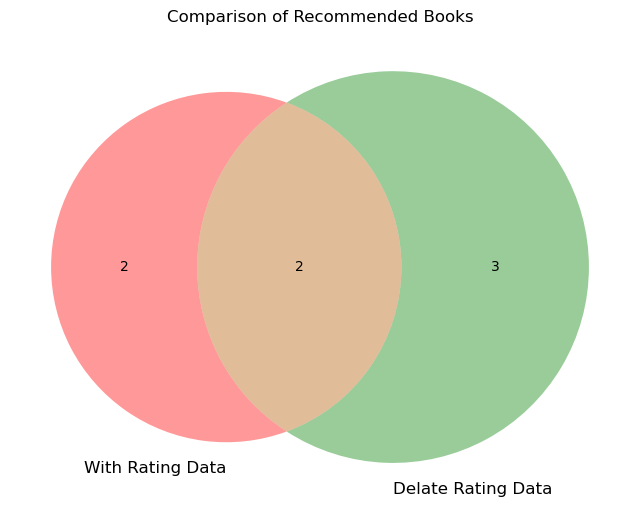

In [153]:

df1_isbns = set(["0060001445", "002026478X", "0004722124", "9022906116"])
df2_isbns = set(["2253007900", "0811824152", "0373650302", "0004722124", "9022906116"])

plt.figure(figsize=(8, 8))
venn2([df1_isbns, df2_isbns], ('With Rating Data', 'Delate Rating Data'))
plt.title('Comparison of Recommended Books')

plt.show()

In [146]:
import difflib

def find_best_match(isbn, choices, cutoff):
    match = difflib.get_close_matches(isbn, choices, n=1, cutoff=cutoff)
    return match[0] if match else None

df1['ISBN'] = df1['ISBN'].astype(str)
df2['ISBN'] = df2['ISBN'].astype(str)

choices = df2['ISBN'].tolist()


df1['matched_ISBN'] = df1['ISBN'].apply(find_best_match, choices=choices, cutoff=0.9)


print(df1[['ISBN', 'matched_ISBN']])

         ISBN matched_ISBN
0  0060001445         None
1  002026478X         None
2  0004722124   0004722124
3  9022906116   9022906116


In [148]:
number_of_matches = df1['matched_ISBN'].notnull().sum()

total_isbns = len(df1['ISBN'])

similarity_percentage = (number_of_matches / total_isbns) * 100

print(f"Similarity Match Percentage: {similarity_percentage:.2f}%")

Similarity Match Percentage: 66.66%
